In [1]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.2' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from temgym_core.source import ParallelBeam
from temgym_core.components import Detector, Lens, Deflector
from temgym_core.gaussian import GaussianRay, evaluate_gaussian_input_image, make_gaussian_image
from temgym_core.utils import fibonacci_spiral, FresnelPropagator
import numpy as np

from __future__ import annotations
import numpy as np
from skimage.restoration import unwrap_phase

from temgym_core.run import run_to_end


jax.config.update("jax_enable_x64", True)

In [2]:
scale = 1  # scale to microns

aperture_window_width = 1e-4
num_aper_pixels = 128
aperture_pixel_size = (aperture_window_width / num_aper_pixels, aperture_window_width / num_aper_pixels)
aperture_radius = aperture_window_width * 0.25

num_beams = int(1)
r1x, r1y = fibonacci_spiral(num_beams, aperture_radius)

wavelength = 1e-8
k = 2 * np.pi / wavelength
wo = 1e-5

aperture_area = np.pi * aperture_radius**2
scale_factor = aperture_area / (wo ** 2 * num_beams * np.pi)

/home/dl277493/Microscope-Calibration/TemGymCore/src/temgym_core/utils.py:310: RuntimeWarning: invalid value encountered in sqrt
  radius * np.sqrt((ii + 0.5) / (nb_samples - 0.5 * (np_boundary + 1)))


In [3]:
# Gaussian Beam Input
xs = r1x + 1e-4 * 0.125
ys = r1y
dxs = np.zeros(num_beams)
dys = np.zeros(num_beams)
zs = np.zeros(num_beams)
pathlengths = np.zeros(num_beams)
ones = np.ones(num_beams)
amplitudes = np.ones(num_beams) * scale_factor
radii_of_curv = np.full((num_beams, 2), np.inf)
theta = np.zeros(num_beams)
wavelength = wavelength
wavelengths = np.full((num_beams,), wavelength)
wo = wo
waist_xy = np.full((num_beams, 2), wo)

rays = GaussianRay(
    x=xs, 
    y=ys, 
    dx=dxs,
    dy=dys, 
    z=zs,
    pathlength=pathlengths, 
    _one=ones, 
    amplitude=amplitudes, 
    waist_xy=waist_xy,  # 1x2 per Gaussian Ray
    radii_of_curv=radii_of_curv,  # 1x2 per Gaussian Ray
    wavelength=wavelengths, 
    theta=theta,
)

input_aperture_grid = Detector(
    pixel_size=aperture_pixel_size,
    shape=(num_aper_pixels, num_aper_pixels),
    z=0.0,
)


In [4]:
# Warm up JIT by evaluating a single-ray batch
rays_single = GaussianRay(
    x=xs[:1],
    y=ys[:1],
    dx=dxs[:1],
    dy=dys[:1],
    z=zs[:1],
    pathlength=pathlengths[:1],
    _one=ones[:1],
    amplitude=amplitudes[:1],
    waist_xy=waist_xy[:1],
    radii_of_curv=radii_of_curv[:1],
    wavelength=wavelengths[:1],
    theta=theta[:1],
)
_ = evaluate_gaussian_input_image(rays_single, input_aperture_grid, batch_size=1)


In [5]:
# Full evaluation
aperture_image = evaluate_gaussian_input_image(rays, input_aperture_grid, batch_size=100)

Text(0.5, 1.0, 'Gauss Phase at input plane')

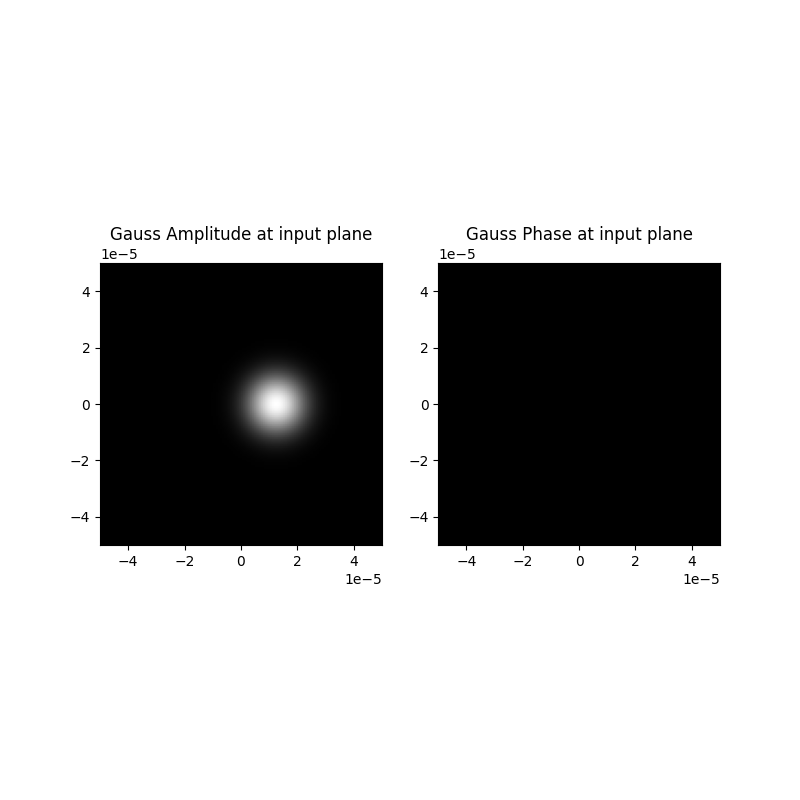

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

# Amplitude at input plane
ax[0].imshow(jnp.abs(aperture_image), cmap='gray', extent=[-aperture_window_width/2, aperture_window_width/2, -aperture_window_width/2, aperture_window_width/2])
ax[0].set_title('Gauss Amplitude at input plane')

# Phase at input plane
ax[1].imshow(jnp.angle(aperture_image), cmap='gray', extent=[-aperture_window_width/2, aperture_window_width/2, -aperture_window_width/2, aperture_window_width/2])
ax[1].set_title('Gauss Phase at input plane')

## Approximating Functions with Gaussian Beams

Constant offset in Slope - Linear in Phase 

In [7]:
defocus = 1e-11
parallel_beam = ParallelBeam(z=0.0, radius=aperture_radius)
deflector = Deflector(z=0.0, def_x = 1e-3, def_y = 0.0)
detector = Detector(z=defocus, pixel_size=(aperture_pixel_size[0], aperture_pixel_size[1]), shape=(num_aper_pixels, num_aper_pixels))
detector_xy = detector.coords_1d
extent_x = detector.coords_1d[0][0], detector.coords_1d[0][-1]
extent_y = detector.coords_1d[1][0], detector.coords_1d[1][-1]

model = [
    parallel_beam,
    deflector,
    detector,
]

input_rays = rays.derive(z=jnp.zeros(num_beams))
gauss_image = make_gaussian_image(input_rays, model, batch_size=100)

In [8]:
detector_coords = detector.coords
X, Y = detector_coords[:, 0], detector_coords[:, 1]
X = X.reshape((num_aper_pixels, num_aper_pixels))
Y = Y.reshape((num_aper_pixels, num_aper_pixels))   

phi_linear = np.exp(1j * k * (deflector.def_x * X + deflector.def_y * Y))
phi_lens = phi_linear * np.abs(aperture_image)

# Zero the phase by subtracting the phase at the center pixel
center_idx = num_aper_pixels // 2
gauss_image += np.angle(gauss_image[center_idx, center_idx])
phi_lens += np.angle(phi_lens[center_idx, center_idx])

# Unwrap the phase of both images
unwrapped_gauss_image = unwrap_phase(np.angle(gauss_image))
unwrapped_phi_lens = unwrap_phase(np.angle(phi_lens))

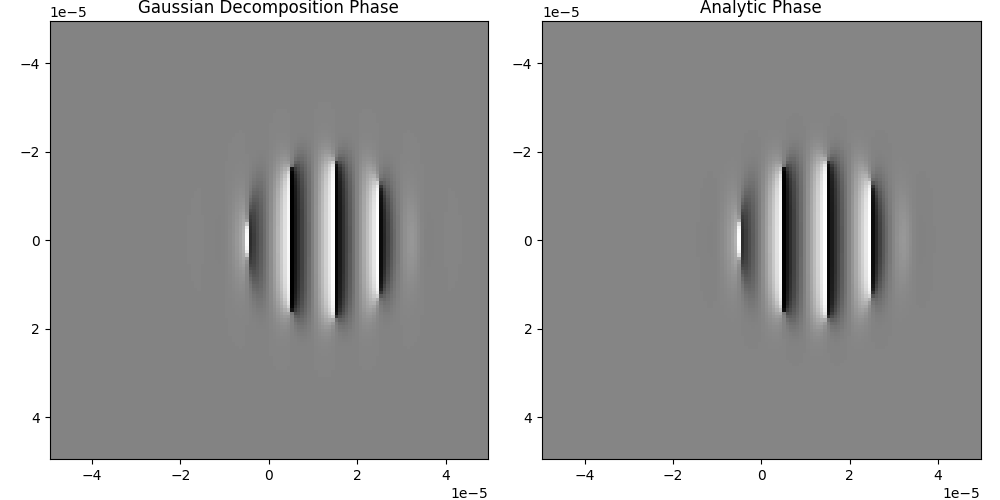

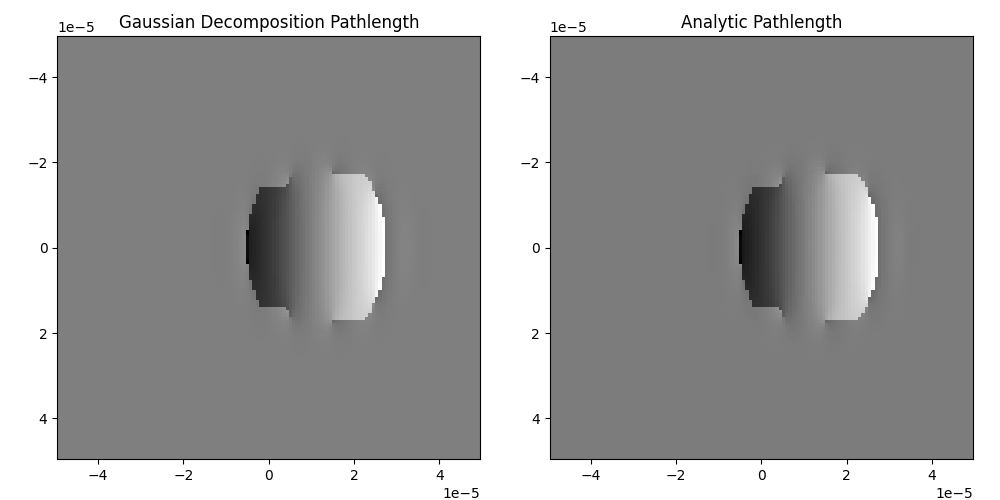

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(jnp.angle(gauss_image), cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[0].set_title('Gaussian Decomposition Phase')
im1 = axs[1].imshow(np.angle(phi_lens), cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[1].set_title('Analytic Phase')
plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(unwrapped_gauss_image, cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[0].set_title('Gaussian Decomposition Pathlength')
im1 = axs[1].imshow(unwrapped_phi_lens, cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[1].set_title('Analytic Pathlength')
plt.tight_layout()

Linear offset in slope, Quadratic in Phase

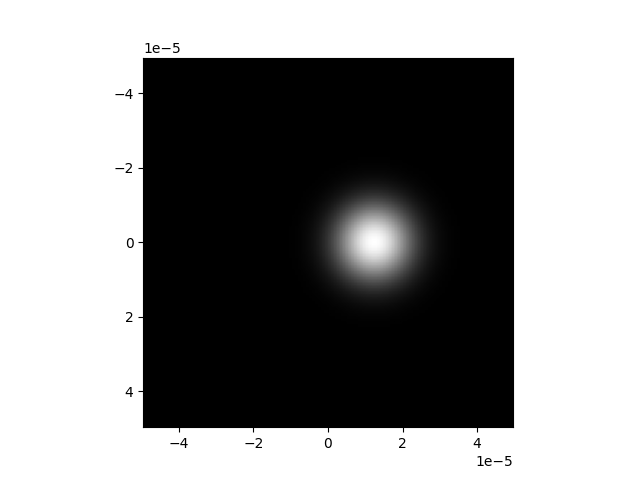

In [10]:
defocus = 1e-11
F1 = 0.01
parallel_beam = ParallelBeam(z=0.0, radius=aperture_radius)
lens = Lens(z=0.0, focal_length=F1)
detector = Detector(z=defocus, pixel_size=(aperture_pixel_size[0], aperture_pixel_size[1]), shape=(num_aper_pixels, num_aper_pixels))
detector_xy = detector.coords_1d
extent_x = detector.coords_1d[0][0], detector.coords_1d[0][-1]
extent_y = detector.coords_1d[1][0], detector.coords_1d[1][-1]

model = [
    parallel_beam,
    lens,
    detector,
]

input_rays = rays.derive(z=jnp.zeros(num_beams))
gauss_image = make_gaussian_image(input_rays, model, batch_size=100)

plt.figure()
plt.imshow(jnp.abs(gauss_image), cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
out_rays = run_to_end(input_rays, model)

In [11]:
detector_coords = detector.coords
X, Y = detector_coords[:, 0], detector_coords[:, 1]
X = X.reshape((num_aper_pixels, num_aper_pixels))
Y = Y.reshape((num_aper_pixels, num_aper_pixels))   

phi_lens = np.exp(1j * (k * (-1/F1) / 2.0) * (X**2 + Y**2))
phi_lens = phi_lens * np.abs(aperture_image)

# mask = (X**2 + Y**2) <= aperture_radius**2
amp = np.abs(aperture_image)

# apply amplitude mask to both images
gauss_image = gauss_image * amp
phi_lens = phi_lens * amp

# build a binary mask (avoid tiny numerical values) and zero outside aperture
thresh = np.max(amp) * 1e-1
mask = amp > thresh

gauss_image = np.where(mask, gauss_image, 0)
phi_lens = np.where(mask, phi_lens, 0)

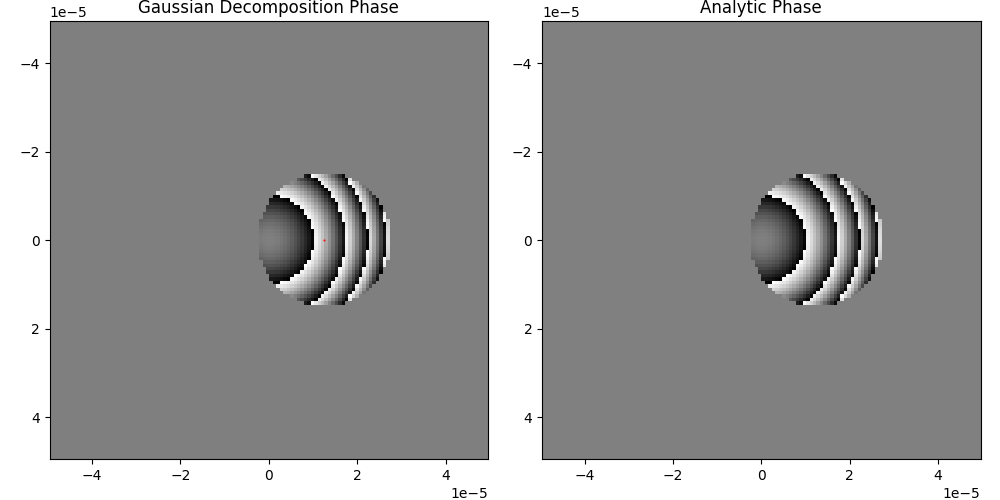

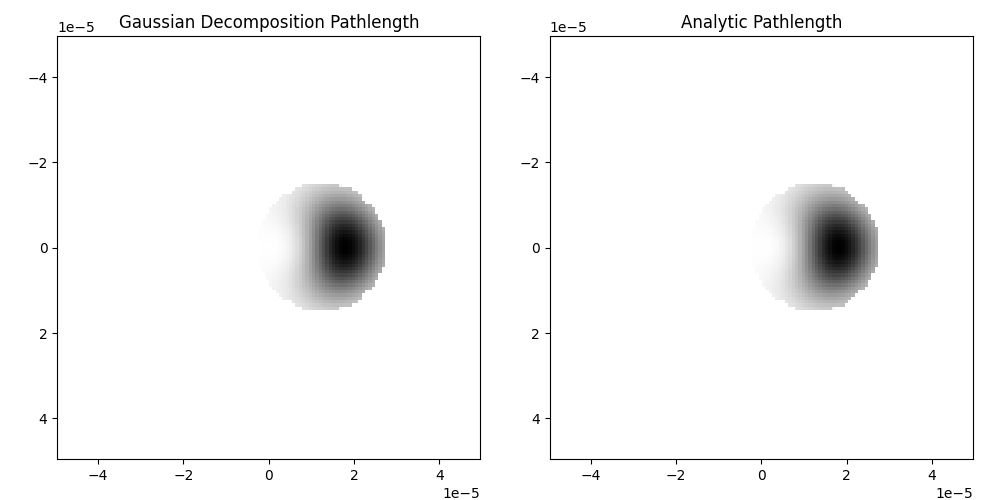

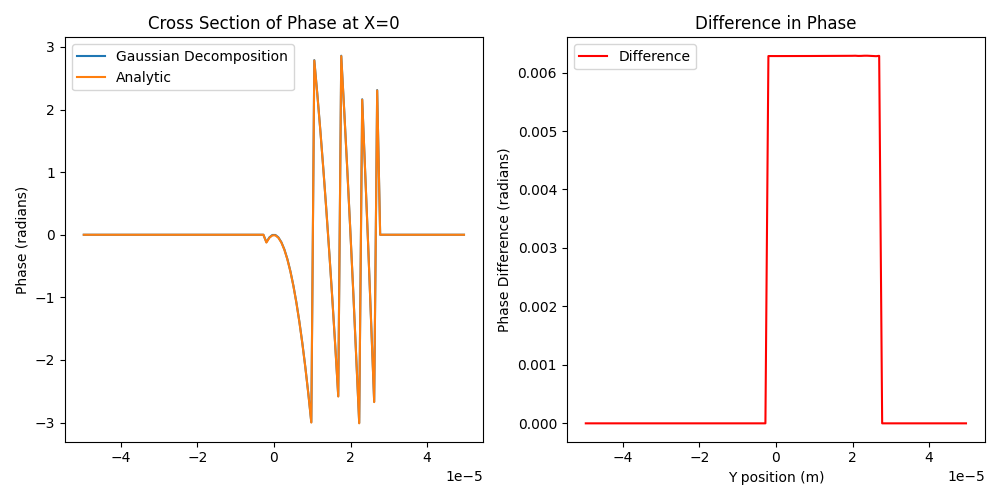

In [12]:
# Unwrap the phase of both images
unwrapped_gauss_image = unwrap_phase(np.angle(gauss_image)) * np.abs(aperture_image)
unwrapped_phi_lens = unwrap_phase(np.angle(phi_lens)) * np.abs(aperture_image)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(jnp.angle(gauss_image), cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[0].set_title('Gaussian Decomposition Phase')
axs[0].plot(out_rays.x, out_rays.y, 'r.', markersize=1)
im1 = axs[1].imshow(np.angle(phi_lens), cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[1].set_title('Analytic Phase')
plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(unwrapped_gauss_image, cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[0].set_title('Gaussian Decomposition Pathlength')
im1 = axs[1].imshow(unwrapped_phi_lens, cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[1].set_title('Analytic Pathlength')
plt.tight_layout()

center_x_idx = num_aper_pixels // 2
gauss_phase_section = np.angle(gauss_image)[center_x_idx, :]
analytic_phase_section = np.angle(phi_lens)[center_x_idx, :]
difference_phase_section = gauss_phase_section - analytic_phase_section

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

ax[0].plot(X[center_x_idx, :], gauss_phase_section, label='Gaussian Decomposition')
ax[0].plot(X[center_x_idx, :], analytic_phase_section, label='Analytic')
ax[0].set_ylabel('Phase (radians)')
ax[0].set_title('Cross Section of Phase at X=0')
ax[0].legend()

ax[1].plot(X[center_x_idx, :], difference_phase_section, label='Difference', color='r')
ax[1].set_xlabel('Y position (m)')
ax[1].set_ylabel('Phase Difference (radians)')
ax[1].set_title('Difference in Phase')
ax[1].legend()

plt.tight_layout()

In [16]:
class NonLinearLens:
    def __init__(self, z: float, focal_length: float, C3: float = 0.0, Coma: float = 0.0):
        self.z = z
        self.focal_length = focal_length
        self.C3 = C3  # Third-order spherical aberration coefficient
        self.Coma = Coma

    def __call__(self, ray):
        f = self.focal_length
        C3 = self.C3
        Coma = self.Coma
        
        x, y, dx, dy = ray.x, ray.y, ray.dx, ray.dy
        r2 = x**2 + y**2
        # Slope deviation due to lens, spherical aberration (C3), and coma
        new_dx = (-x / f) + C3*x*(r2) + Coma*(r2) + dx
        new_dy = (-y / f) + C3*y*(r2) + 2*Coma*x*y + dy

        pathlengths = ray.pathlength  -r2 / (2 * F1) + C3 * r2**2 + Coma  * x * r2
        return ray.derive(
            x=x, y=y, dx=new_dx, dy=new_dy, z=ray.z
        )

C3 = 1e9
Coma = 1e9
F1 = 0.01
defocus = 1e-12
parallel_beam = ParallelBeam(z=0.0, radius=aperture_radius)
nonlinearlens = NonLinearLens(z=0.0, focal_length=F1, C3=C3, Coma=Coma)
detector = Detector(z=defocus, pixel_size=(aperture_pixel_size[0], aperture_pixel_size[1]), shape=(num_aper_pixels, num_aper_pixels))
detector_xy = detector.coords_1d
extent_x = detector.coords_1d[0][0], detector.coords_1d[0][-1]
extent_y = detector.coords_1d[1][0], detector.coords_1d[1][-1]

model = [
    parallel_beam,
    nonlinearlens,
    detector,
]

input_rays = rays.derive(z=jnp.zeros(num_beams))
gauss_image = make_gaussian_image(input_rays, model, batch_size=100)

In [17]:
import sympy as sp

detector_coords = detector.coords
X, Y = detector_coords[:, 0], detector_coords[:, 1]
X = X.reshape((num_aper_pixels, num_aper_pixels))
Y = Y.reshape((num_aper_pixels, num_aper_pixels))   
r2 = X**2 + Y**2
phi_nonlinear_lens = np.exp(1j * k * (-r2 / (2 * F1) + C3 * r2**2 + Coma  * X * r2))

mask = (X**2 + Y**2) <= aperture_radius**2
phi_nonlinear_lens = phi_nonlinear_lens * mask
gauss_image = gauss_image * mask
print(np.where(np.isnan(gauss_image)))

# build a binary mask (avoid tiny numerical values) and zero outside aperture
thresh = np.max(amp) * 1e-1
mask = amp > thresh

gauss_image = np.where(mask, gauss_image, 0)
phi_nonlinear_lens = np.where(mask, phi_nonlinear_lens, 0)

(array([], dtype=int64), array([], dtype=int64))


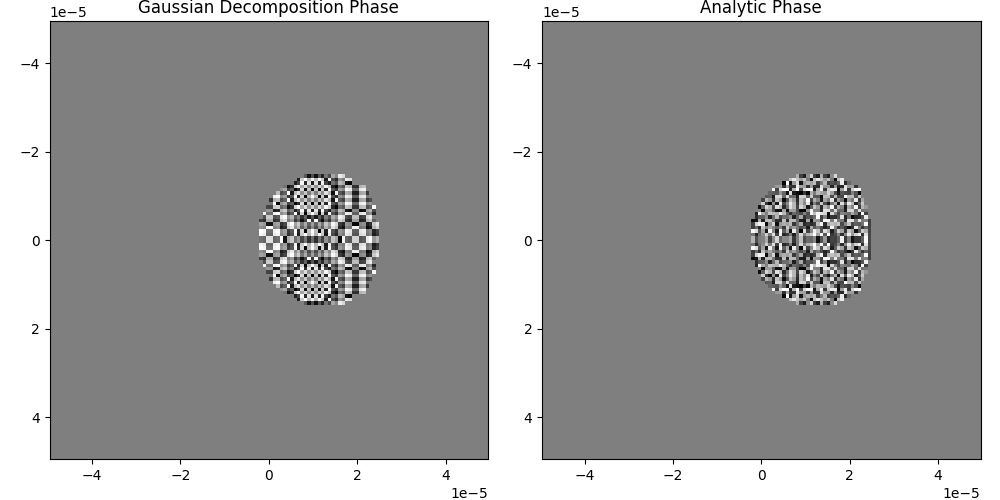

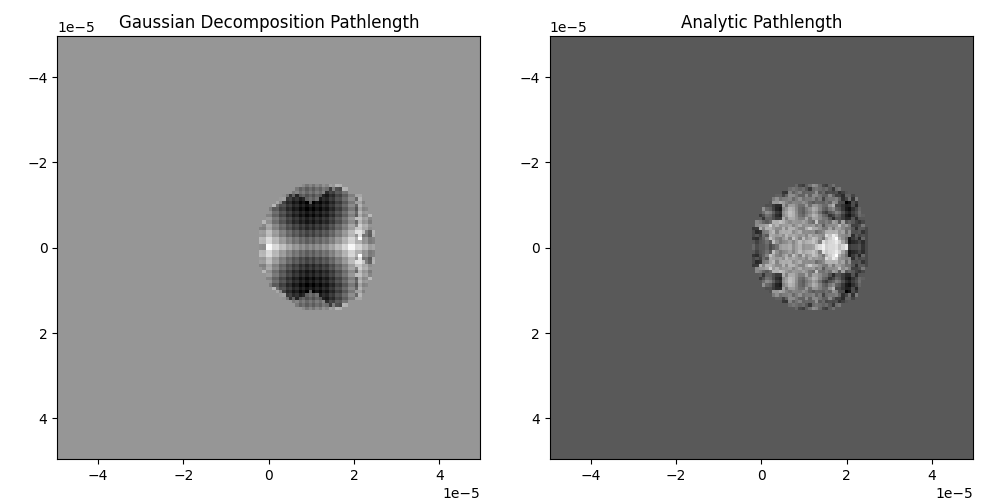

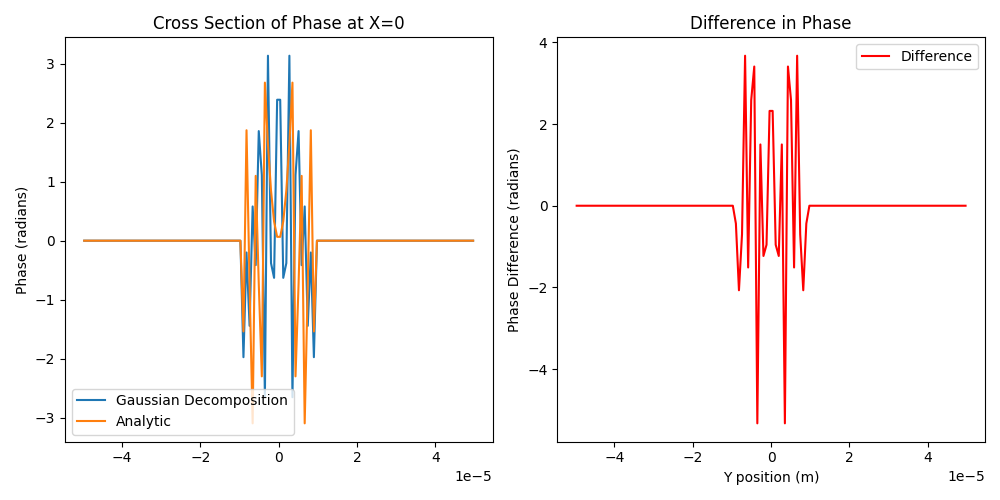

In [18]:
# Unwrap the phase of both images
unwrapped_gauss_image = unwrap_phase(np.angle(gauss_image))
unwrapped_phi_nonlinear_lens = unwrap_phase(np.angle(phi_nonlinear_lens))
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(jnp.angle(gauss_image), cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[0].set_title('Gaussian Decomposition Phase')
im1 = axs[1].imshow(np.angle(phi_nonlinear_lens), cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[1].set_title('Analytic Phase')
plt.tight_layout()


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(unwrapped_gauss_image, cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[0].set_title('Gaussian Decomposition Pathlength')
im1 = axs[1].imshow(unwrapped_phi_nonlinear_lens, cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[1].set_title('Analytic Pathlength')
plt.tight_layout()

center_x_idx = num_aper_pixels // 2

gauss_phase_section = np.angle(gauss_image)[:, center_x_idx]
analytic_phase_section = np.angle(phi_nonlinear_lens)[:, center_x_idx]
difference_phase_section = gauss_phase_section - analytic_phase_section

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

ax[0].plot(Y[:, center_x_idx], gauss_phase_section, label='Gaussian Decomposition')
ax[0].plot(Y[:, center_x_idx], analytic_phase_section, label='Analytic')
ax[0].set_ylabel('Phase (radians)')
ax[0].set_title('Cross Section of Phase at X=0')
ax[0].legend()

ax[1].plot(Y[:, center_x_idx], difference_phase_section, label='Difference', color='r')
ax[1].set_xlabel('Y position (m)')
ax[1].set_ylabel('Phase Difference (radians)')
ax[1].set_title('Difference in Phase')
ax[1].legend()

plt.tight_layout()
